# Wine Rating Prediction System

## Introduction

In this notebook, we will test different machine learning models to predict wine ratings based on various features. This builds on the exploratory data analysis (EDA) we conducted in the previous notebook. Our goal is to evaluate the performance of different models and identify the best approach for predicting wine ratings.

We will use the following models:
1. Linear Regression
2. Support Vector Regression (SVR)
3. Random Forest Regressor

Additionally, we will preprocess the text data using techniques like CountVectorizer and Word2Vec to extract meaningful features from wine descriptions.

Let's start by importing the necessary libraries and loading the dataset.

In [18]:
# Importing necessary libraries
import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter, defaultdict

# More imports for our traditional machine learning
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import re
from datasets import load_dataset, Dataset, DatasetDict

In [19]:
# Import dataset
wine_df = pd.read_csv("wine_df.csv")

In [20]:
def scrub(stuff):
    """
    Clean up the provided text by removing unnecessary characters and whitespace.
    
    Args:
        stuff (str): The input text to be cleaned.
        
    Returns:
        str: The cleaned text.
    """
    
    stuff = re.sub(r'[:\[\]"{}【】\s]+', ' ', stuff).strip() # Remove specific characters and extra whitespace
   
    stuff = stuff.replace(" ,", ",").replace(",,,",",").replace(",,",",")  # Remove commas and other unwanted characters
    
    words = stuff.split(' ') # Split the text into words and join them back with single spaces
    return " ".join(words)

In [21]:
# Create a list of formatted strings
items = []
# Iterate over each row in the DataFrame
for _, row in wine_df.iterrows():
    # Check if the 'year' column is not NaN
    if pd.notna(row['year']):
        # Format the string with year included
        formatted_item = (
            "What is the wine rating to the nearest whole number in range 85 to 100?\n\n"
            f"The {scrub(row['variety'])} name is {scrub(row['name'])} and it was produced in {scrub(row['region'])} in {int(row['year'])}.\n"
            f"{scrub(row['notes'])}\n\n"
            f"The rating is {int(row['rating'])}"
        )
        items.append(formatted_item)
    else:
        # Format the string without year
        formatted_item = (
            "What is the wine rating to the nearest whole number in range 85 to 100?\n\n"
            f"The {scrub(row['variety'])} name is {scrub(row['name'])} and it was produced in {scrub(row['region'])}.\n"
            f"{scrub(row['notes'])}\n\n"
            f"The rating is {int(row['rating'])}"
        )
        items.append(formatted_item)
    

In [22]:
print(items[33172])

What is the wine rating to the nearest whole number in range 85 to 100?

The Red Wine name is Leacock's 10 Year Bual Madiera and it was produced in Portugal.
Clear, amber colour with golden highlights. A complex and intense aroma of dried fruits (fig, prunes, almonds), toffee and vanilla-spice. Medium sweet, smooth, soft fruit, balanced by a strong backbone of citrus acidity and a luxurious, long finish.

The rating is 88


In [23]:
print(f"A grand total of {len(items):,} items")

A grand total of 33,177 items


In [24]:
# Set a random seed for reproducibility
random.seed(42)

# Shuffle the items to ensure randomness in the training and test sets
random.shuffle(items)

# Split the items into training and test sets
train = items[:30_000]  # First 30,000 items for training
test = items[30_000:]   # Remaining items for testing

# Print the sizes of the training and test sets
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 30,000 items and test set of 3,177 items


In [25]:
def test_prompt(prompt):
    """
    Return a prompt suitable for testing, with the actual rating removed.
    
    Args:
        prompt (str): The input prompt containing the wine description and rating.
        
    Returns:
        str: The prompt with the actual rating removed.
    """
    
    PREFIX = "The rating is "
    return prompt.split(PREFIX)[0] + PREFIX

In [26]:
print(test_prompt(test[0])) # Test the test_prompt function on the first item in the test set

What is the wine rating to the nearest whole number in range 85 to 100?

The Red Wine name is Calina Reserva Merlot 2006 and it was produced in Chile in 2006.
The wide variations in temperature from day to night bring on intense fruit character and deep ruby color in the vineyards of Maule Valley. Here, plum and blackberry emerge in the nose, to combine with sweet oak and a light background of mint. Good weight and smooth tannins give way to a long finish. -Andres Sanchez, Winemaker

The rating is 


In [27]:
# Extract prompts and ratings from the training set
train_prompts = [item for item in train]  # List of training prompts
train_ratings = [int(item[-3:]) for item in train]  # Extract ratings (last 3 characters) from training prompts

# Extract prompts and ratings from the test set
test_prompts = [test_prompt(item) for item in test]  # List of test prompts with ratings removed
test_ratings = [int(item[-3:]) for item in test]  # Extract ratings (last 3 characters) from test prompts

In [28]:
# Create a Dataset from the lists
train_dataset = Dataset.from_dict({"prompt": train_prompts, "rating": train_ratings})  # Training dataset
test_dataset = Dataset.from_dict({"prompt": test_prompts, "rating": test_ratings})  # Test dataset

In [29]:
# Save the datasets to pickle files for future use
with open('train_wine.pkl', 'wb') as file:
    pickle.dump(train_dataset, file)  # Save training dataset to a pickle file

with open('test_wine.pkl', 'wb') as file:
    pickle.dump(test_dataset, file)  # Save test dataset to a pickle file

In [31]:
# environment

load_dotenv()
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [35]:
with open('train_wine.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_wine.pkl', 'rb') as file:
    test = pickle.load(file)

## Model Testing and Evaluation

In this section, we will evaluate the performance of our wine rating prediction model using a custom `Tester` class. This class allows us to:
- Run predictions on test data.
- Calculate errors and log errors.
- Visualize the results using scatter plots.
- Generate a performance report with metrics like average error, RMSLE (Root Mean Squared Log Error), and hit rate.

We will also use color-coded output to quickly identify the accuracy of predictions:
- **Green**: Error < 1
- **Orange**: Error < 3
- **Red**: Error ≥ 3

Let's dive into the implementation and evaluation process.

In [41]:
# Define color codes for terminal output
GREEN = "\033[92m"  # Green color for low error
YELLOW = "\033[93m"  # Yellow color for moderate error
RED = "\033[91m"  # Red color for high error
RESET = "\033[0m"  # Reset color to default
COLOR_MAP = {"red": RED, "orange": YELLOW, "green": GREEN}  # Map error levels to colors

In [42]:

class Tester:
    """
    A class to test and evaluate the performance of a wine rating predictor.
    """

    def __init__(self, predictor, title=None, data=test, size=3000):

        """
        Initialize the Tester with a predictor function, dataset, and optional title.
        
        Args:
            predictor: The function used to predict wine ratings.
            title (str, optional): A title for the test. Defaults to the predictor's name.
            data: The dataset to test on. Defaults to the test dataset.
            size (int): The number of datapoints to test. Defaults to 3000.
        """

        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        """
        Determine the color for the error level.
        
        Args:
            error (float): The absolute error between prediction and truth.
            truth (float): The ground truth rating.
            
        Returns:
            str: The color corresponding to the error level ("green", "orange", or "red").
        """

        if error<1:
            return "green"
        elif error<3:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):

        """
        Run the predictor on a single datapoint and store the results.
        
        Args:
            i (int): The index of the datapoint in the dataset.
        """

        datapoint = self.data[i]
        guess = self.predictor(datapoint['prompt'])
        truth = datapoint['rating']
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint['prompt'][73:-18] if len(datapoint['prompt'][73:-18]) <= 40 else datapoint['prompt'][73:-18][:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: {guess:,.2f} Truth: {truth:,.2f} Error: {error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):

        """
        Generate a scatter plot to visualize model predictions vs ground truth.
        
        Args:
            title (str): The title of the chart.
        """

        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        min_val = min(min(self.truths), min(self.guesses))
        plt.plot([min_val, max_val], [min_val, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        plt.title(title)
        plt.show()

    def report(self):

        """
        Generate a performance report with average error, RMSLE, and hit rate.
        """

        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error= {average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):

        """
        Run the tester on the specified number of datapoints.
        """

        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):

        """
        A class method to quickly test a predictor function.
        
        Args:
            function: The predictor function to test.
        """

        cls(function).run()

## Testing a Random Rating Predictor

In this section, we will test a simple random rating predictor to establish a baseline for our model evaluation. The random rating predictor generates ratings uniformly distributed between 80 and 100. This baseline helps us understand the performance of more sophisticated models by comparing their results to random predictions.

We will use the `Tester` class to evaluate the random rating predictor and visualize its performance.

In [43]:
def random_rating(item):
    """
    Generate a random rating between 80 and 100.
    
    Args:
        item: The input item (not used in this function).
        
    Returns:
        int: A random integer between 80 and 100.
    """
    return random.randrange(80, 100)

1: Guess: 83.00 Truth: 89.00 Error: 6.00 SLE: 0.00 Item: The Red Wine name is Calina Reserva Merl...
2: Guess: 80.00 Truth: 93.00 Error: 13.00 SLE: 0.02 Item: The Red Wine name is Chateau Montrose (3...
3: Guess: 88.00 Truth: 92.00 Error: 4.00 SLE: 0.00 Item: The Red Wine name is Castellare I Sodi S...
4: Guess: 87.00 Truth: 98.00 Error: 11.00 SLE: 0.01 Item: The Red Wine name is Abreu Vineyards Mad...
5: Guess: 87.00 Truth: 90.00 Error: 3.00 SLE: 0.00 Item: The White Wine name is Carlson Santa Yne...
6: Guess: 84.00 Truth: 90.00 Error: 6.00 SLE: 0.00 Item: The Pink and Rosé name is Chateau de Lan...
7: Guess: 83.00 Truth: 97.00 Error: 14.00 SLE: 0.02 Item: The White Wine name is Kistler Vineyards...
8: Guess: 97.00 Truth: 94.00 Error: 3.00 SLE: 0.00 Item: The Red Wine name is Betz Family Winery ...
9: Guess: 82.00 Truth: 93.00 Error: 11.00 SLE: 0.02 Item: The Red Wine name is Bond Quella 2011 an...
10: Guess: 98.00 Truth: 90.00 Error: 8.00 SLE: 0.01 Item: The Red Wine name is Avignone

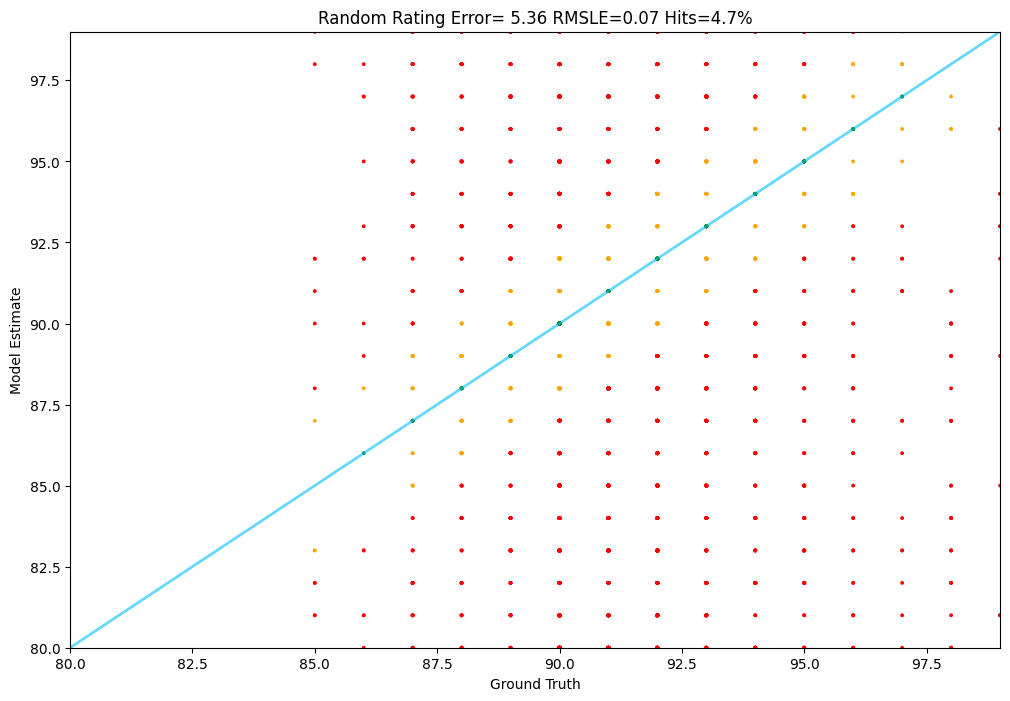

In [272]:
# Set the random seed for reproducibility
random.seed(42)

# Run the Tester on the random_rating predictor
Tester.test(random_rating)

## Results of Random Rating Predictor

The random rating predictor achieved the following performance metrics:
- **Average Error**: 5.36
- **RMSLE (Root Mean Squared Log Error)**: 0.07
- **Hit Rate**: 4.7%

The scatter plot below shows the relationship between the predicted ratings and the ground truth ratings. The blue line represents the ideal scenario where predictions match the ground truth exactly. The points are color-coded based on the error level:
- **Green**: Error < 1
- **Orange**: Error < 3
- **Red**: Error ≥ 3

As expected, the random rating predictor performs poorly, with most predictions falling far from the ground truth. This baseline will help us evaluate the effectiveness of more advanced models.

## Testing a Constant Rating Predictor

In this section, we will test a constant rating predictor, which always predicts the average rating from the training set. This model serves as another baseline to compare against more sophisticated models. While it is still a simple approach, it is expected to perform better than the random rating predictor since it leverages the central tendency of the training data.

We will use the `Tester` class to evaluate the constant rating predictor and visualize its performance.

In [44]:
# Calculate the average rating from the training set
training_prices = [item['rating'] for item in train]  # Extract ratings from the training set
training_average = sum(training_prices) / len(training_prices)  # Calculate the average rating

def constant_rating(item):
    """
    Predict the constant average rating for any input item.
    
    Args:
        item: The input item (not used in this function).
        
    Returns:
        float: The constant average rating from the training set.
    """
    return training_average

1: Guess: 91.18 Truth: 89.00 Error: 2.18 SLE: 0.00 Item: The Red Wine name is Calina Reserva Merl...
2: Guess: 91.18 Truth: 93.00 Error: 1.82 SLE: 0.00 Item: The Red Wine name is Chateau Montrose (3...
3: Guess: 91.18 Truth: 92.00 Error: 0.82 SLE: 0.00 Item: The Red Wine name is Castellare I Sodi S...
4: Guess: 91.18 Truth: 98.00 Error: 6.82 SLE: 0.01 Item: The Red Wine name is Abreu Vineyards Mad...
5: Guess: 91.18 Truth: 90.00 Error: 1.18 SLE: 0.00 Item: The White Wine name is Carlson Santa Yne...
6: Guess: 91.18 Truth: 90.00 Error: 1.18 SLE: 0.00 Item: The Pink and Rosé name is Chateau de Lan...
7: Guess: 91.18 Truth: 97.00 Error: 5.82 SLE: 0.00 Item: The White Wine name is Kistler Vineyards...
8: Guess: 91.18 Truth: 94.00 Error: 2.82 SLE: 0.00 Item: The Red Wine name is Betz Family Winery ...
9: Guess: 91.18 Truth: 93.00 Error: 1.82 SLE: 0.00 Item: The Red Wine name is Bond Quella 2011 an...
10: Guess: 91.18 Truth: 90.00 Error: 1.18 SLE: 0.00 Item: The Red Wine name is Avignonesi V

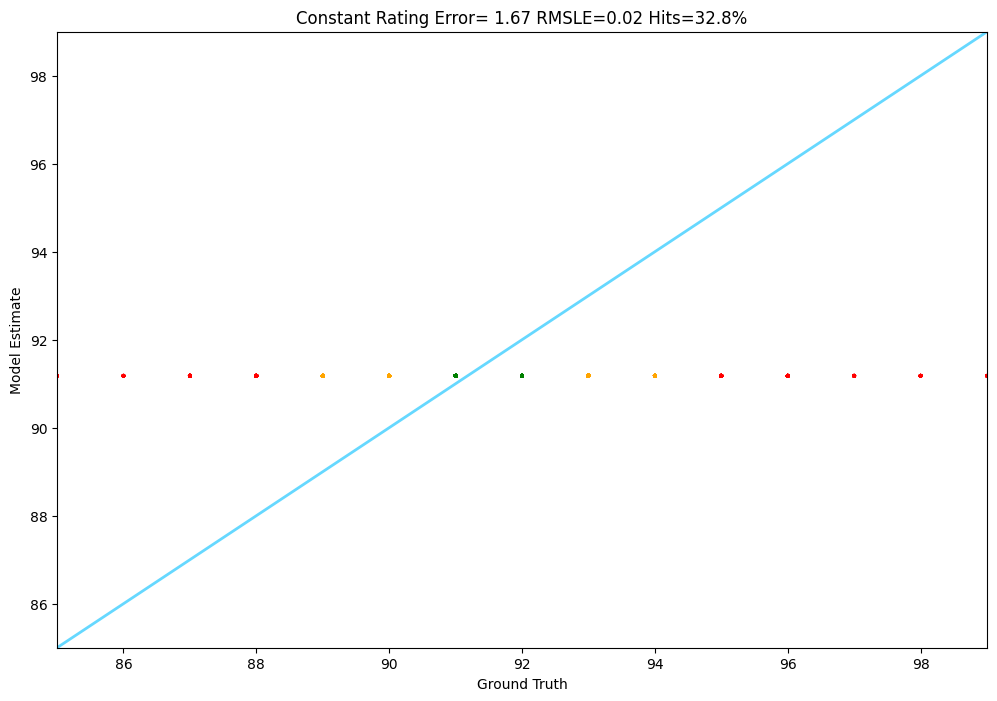

In [274]:
# Run the Tester on the constant_rating predictor
Tester.test(constant_rating)


## Results of Constant Rating Predictor

The constant rating predictor achieved the following performance metrics:
- **Average Error**: 1.67
- **RMSLE (Root Mean Squared Log Error)**: 0.02
- **Hit Rate**: 32.8%

The scatter plot below shows the relationship between the predicted ratings and the ground truth ratings. The blue line represents the ideal scenario where predictions match the ground truth exactly. The points are color-coded based on the error level:
- **Green**: Error < 1
- **Orange**: Error < 3
- **Red**: Error ≥ 3

The constant rating predictor performs significantly better than the random rating predictor, with a lower average error and a higher hit rate. However, it still lacks the ability to capture variations in the data, as it always predicts the same value.

## Linear Regression Model for Wine Rating Prediction

In this section, we will implement a linear regression model to predict wine ratings based on features such as the year of production, wine variety, and region. Linear regression is a simple yet powerful model that can help us understand the relationship between these features and the wine ratings.

We will:
1. Extract features from the wine descriptions.
2. Train a linear regression model on the training data.
3. Evaluate the model's performance on the test data.
4. Compare the results to our previous baseline models.

In [45]:
def get_features(text):
    """
    Extract features from the wine description text.
    
    Args:
        text (str): The wine description text.
        
    Returns:
        dict: A dictionary containing the extracted features (year, variety, regions).
    """
    # Extract year
    year_match = re.search(r'\b(19|20)\d{2}\b', text)
    year = int(year_match.group()) if year_match else 1
    
    # Extract wine variety
    wine_varieties = ['Red Wine', 'White Wine', 'Sparkling & Champagne', 'Pink and Rosé','Boutique', 'Collectible', 'Green Wine', 'Screw Cap']
    # Create a mapping of wine varieties to integers using enumeration
    wine_varieties_map = {variety: idx for idx, variety in enumerate(wine_varieties)}
    
    # Extract wine variety
    variety = None
    for wine in wine_varieties:
        if wine in text:
            variety = wine_varieties_map[wine]
            break
    
    # List of countries to look for
    countries = [
        'California', 'Spain', 'Washington', 'Chile', 'Australia',
        'New Zealand', 'Germany', 'Italy', 'France', 'Portugal', 'Oregon',
        'Argentina', 'Greece', 'South Africa', 'Austria', 'Other U.S.',
        'China', 'Israel', 'Uruguay', 'England', 'Mexico', 'Lebanon',
        'Hungary', 'Switzerland', 'Canada', 'Slovenia', 'Turkey'
    ]
    
    countries_map = {country: idx for idx, country in enumerate(countries)}
    
    # Extract countries from text
    regions = []
    for country in countries:
        if country in text:
            regions.append(countries_map[country])
    
    regions = list(set(regions))  # Get unique regions (as integers)
    
    # Convert regions to categorical variable
    regions_cat = pd.Categorical(regions) if regions else None

    return {
        'year': year,
        'variety': variety,
        'regions': regions[0]
    }



In [46]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):

    """
    Convert a list of items into a pandas DataFrame with extracted features.
    
    Args:
        items (list): A list of items containing wine descriptions and ratings.
        
    Returns:
        pd.DataFrame: A DataFrame with features and ratings.
    """

    features = [get_features(item['prompt']) for item in items]
    df = pd.DataFrame(features)
    df['rating'] = [item['rating'] for item in items]
    return df

# Convert training and test data to DataFrames
train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test)

In [47]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['year', 'variety', 'regions']

# Separate features and target
X_train = train_df[feature_columns]
y_train = train_df['rating']
X_test = test_df[feature_columns]
y_test = test_df['rating']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Print model coefficients and intercept
for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

year: 0.0002489762728641644
variety: -0.11608690788783815
regions: 0.013984495064689711
Intercept: 90.66641325335179
Mean Squared Error: 4.706186580383402
R-squared Score: 0.004089231323492704


In [48]:
# Function to predict price for a new item

def linear_regression_rating(item):

    """
    Predict the wine rating using the trained linear regression model.
    
    Args:
        item: The input item containing the wine description.
        
    Returns:
        float: The predicted wine rating.
    """

    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: 91.21 Truth: 89.00 Error: 2.21 SLE: 0.00 Item: The Red Wine name is Calina Reserva Merl...
2: Guess: 91.28 Truth: 93.00 Error: 1.72 SLE: 0.00 Item: The Red Wine name is Chateau Montrose (3...
3: Guess: 91.26 Truth: 92.00 Error: 0.74 SLE: 0.00 Item: The Red Wine name is Castellare I Sodi S...
4: Guess: 91.16 Truth: 98.00 Error: 6.84 SLE: 0.01 Item: The Red Wine name is Abreu Vineyards Mad...
5: Guess: 91.05 Truth: 90.00 Error: 1.05 SLE: 0.00 Item: The White Wine name is Carlson Santa Yne...
6: Guess: 90.93 Truth: 90.00 Error: 0.93 SLE: 0.00 Item: The Pink and Rosé name is Chateau de Lan...
7: Guess: 91.05 Truth: 97.00 Error: 5.95 SLE: 0.00 Item: The White Wine name is Kistler Vineyards...
8: Guess: 91.20 Truth: 94.00 Error: 2.80 SLE: 0.00 Item: The Red Wine name is Betz Family Winery ...
9: Guess: 91.17 Truth: 93.00 Error: 1.83 SLE: 0.00 Item: The Red Wine name is Bond Quella 2011 an...
10: Guess: 91.27 Truth: 90.00 Error: 1.27 SLE: 0.00 Item: The Red Wine name is Avignonesi V

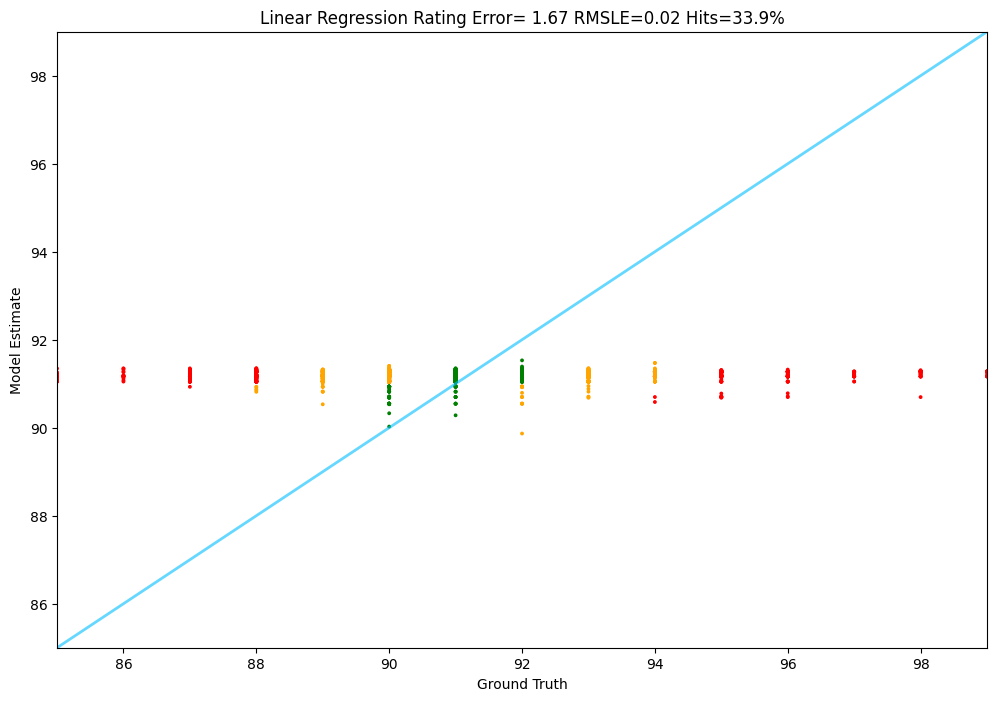

In [279]:
# Test the linear regression model

Tester.test(linear_regression_rating)

## Results of Linear Regression Model

The linear regression model achieved the following performance metrics:
- **Average Error**: 1.67
- **RMSLE (Root Mean Squared Log Error)**: 0.02
- **Hit Rate**: 33.9%

The scatter plot below shows the relationship between the predicted ratings and the ground truth ratings. The blue line represents the ideal scenario where predictions match the ground truth exactly. The points are color-coded based on the error level:
- **Green**: Error < 1
- **Orange**: Error < 3
- **Red**: Error ≥ 3

The linear regression model performs similarly to the constant rating predictor, indicating that the extracted features (year, variety, and region) do not significantly improve the predictions. This suggests that more sophisticated feature engineering or models may be needed to capture the complexity of wine ratings.

## Bag of Words (BoW) Model with Linear Regression

In this section, we will implement a Bag of Words (BoW) model combined with linear regression to predict wine ratings. The BoW model converts text data into numerical features by counting the frequency of words in the wine descriptions. This approach allows us to capture some of the textual information that might influence wine ratings.

We will:
1. Preprocess the wine descriptions using the `CountVectorizer`.
2. Train a linear regression model on the BoW features.
3. Evaluate the model's performance on the test data.
4. Compare the results to our previous models.

In [49]:
# Prepare the documents and ratings for the BoW model
# Note that we use the test_prompt function for the documents to avoid revealing the answer

ratings = np.array([item['rating'] for item in train])  # Extract ratings from the training set
documents = [test_prompt(item['prompt']) for item in train]  # Extract and preprocess wine descriptions

In [50]:
# Use the CountVectorizer for a Bag of Words model
np.random.seed(42)  # Set random seed for reproducibility
vectorizer = CountVectorizer(max_features=1000, stop_words='english')  # Limit to 1000 most frequent words and remove stop words
X = vectorizer.fit_transform(documents)  # Convert documents to BoW features

# Train a Linear Regression model on the BoW features
regressor = LinearRegression()
regressor.fit(X, ratings)

LinearRegression()

In [51]:
def bow_lr_rating(item):
    """
    Predict the wine rating using the BoW model with linear regression.
    
    Args:
        item: The input item containing the wine description.
        
    Returns:
        float: The predicted wine rating.
    """

    x = vectorizer.transform([test_prompt(item)])  # Convert the input text to BoW features
    return max(regressor.predict(x)[0], 0)  # Ensure the prediction is non-negative

1: Guess: 90.27 Truth: 89.00 Error: 1.27 SLE: 0.00 Item: The Red Wine name is Calina Reserva Merl...
2: Guess: 93.48 Truth: 93.00 Error: 0.48 SLE: 0.00 Item: The Red Wine name is Chateau Montrose (3...
3: Guess: 89.78 Truth: 92.00 Error: 2.22 SLE: 0.00 Item: The Red Wine name is Castellare I Sodi S...
4: Guess: 92.30 Truth: 98.00 Error: 5.70 SLE: 0.00 Item: The Red Wine name is Abreu Vineyards Mad...
5: Guess: 90.48 Truth: 90.00 Error: 0.48 SLE: 0.00 Item: The White Wine name is Carlson Santa Yne...
6: Guess: 90.49 Truth: 90.00 Error: 0.49 SLE: 0.00 Item: The Pink and Rosé name is Chateau de Lan...
7: Guess: 91.88 Truth: 97.00 Error: 5.12 SLE: 0.00 Item: The White Wine name is Kistler Vineyards...
8: Guess: 92.51 Truth: 94.00 Error: 1.49 SLE: 0.00 Item: The Red Wine name is Betz Family Winery ...
9: Guess: 92.88 Truth: 93.00 Error: 0.12 SLE: 0.00 Item: The Red Wine name is Bond Quella 2011 an...
10: Guess: 91.06 Truth: 90.00 Error: 1.06 SLE: 0.00 Item: The Red Wine name is Avignonesi V

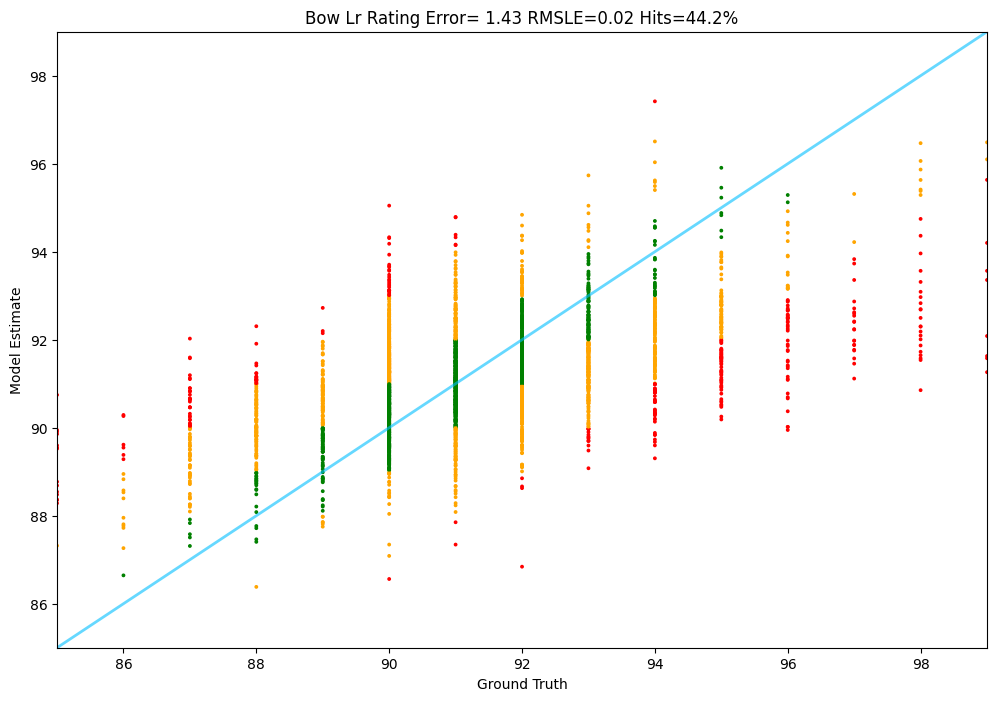

In [52]:
# Test the BoW model with linear regression

Tester.test(bow_lr_rating)

## Results of Bag of Words (BoW) Model with Linear Regression

The BoW model with linear regression achieved the following performance metrics:
- **Average Error**: 1.43
- **RMSLE (Root Mean Squared Log Error)**: 0.02
- **Hit Rate**: 44.2%

The scatter plot below shows the relationship between the predicted ratings and the ground truth ratings. The blue line represents the ideal scenario where predictions match the ground truth exactly. The points are color-coded based on the error level:
- **Green**: Error < 1
- **Orange**: Error < 3
- **Red**: Error ≥ 3

The BoW model with linear regression performs better than the previous models, with a lower average error and a higher hit rate. This indicates that the textual information in the wine descriptions provides useful features for predicting ratings. However, there is still room for improvement, as the model does not capture all the nuances in the data.

## Word2Vec Model with Linear Regression

In this section, we will implement a Word2Vec model combined with linear regression to predict wine ratings. Word2Vec is a powerful NLP technique that captures semantic relationships between words by representing them as vectors in a high-dimensional space. By averaging these word vectors for each wine description, we can create a numerical representation of the text that captures its meaning.

We will:
1. Preprocess the wine descriptions and train a Word2Vec model.
2. Create document vectors by averaging word vectors.
3. Train a linear regression model on the Word2Vec features.
4. Evaluate the model's performance on the test data.
5. Compare the results to our previous models.

In [285]:
# The amazing Word2Vec model, implemented in the Gensim NLP library
np.random.seed(42)  # Set random seed for reproducibility

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]  # Tokenize and preprocess each document

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)
# vector_size: Dimensionality of the word vectors
# window: Maximum distance between the current and predicted word within a sentence
# min_count: Ignores words with a frequency lower than this
# workers: Number of CPU cores to use

In [286]:
# Function to create document vectors by averaging word vectors
def document_vector(doc):
    """
    Create a document vector by averaging the word vectors of the words in the document.
    
    Args:
        doc (str): The input document (wine description).
        
    Returns:
        np.array: The averaged word vector for the document.
    """
    doc_words = simple_preprocess(doc)  # Tokenize and preprocess the document
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]  # Get word vectors for words in the document
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)  # Return the mean vector or a zero vector if no words are found

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [287]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, ratings)

LinearRegression()

In [288]:
def word2vec_lr_pricer(item):
    """
    Predict the wine rating using the Word2Vec model with linear regression.
    
    Args:
        item: The input item containing the wine description.
        
    Returns:
        float: The predicted wine rating.
    """
    doc = test_prompt(item)  # Preprocess the input text
    doc_vector = document_vector(doc)  # Convert the document to a Word2Vec feature vector
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])  # Ensure the prediction is non-negative

1: Guess: 89.20 Truth: 89.00 Error: 0.20 SLE: 0.00 Item: The Red Wine name is Calina Reserva Merl...
2: Guess: 93.79 Truth: 93.00 Error: 0.79 SLE: 0.00 Item: The Red Wine name is Chateau Montrose (3...
3: Guess: 90.32 Truth: 92.00 Error: 1.68 SLE: 0.00 Item: The Red Wine name is Castellare I Sodi S...
4: Guess: 91.67 Truth: 98.00 Error: 6.33 SLE: 0.00 Item: The Red Wine name is Abreu Vineyards Mad...
5: Guess: 90.78 Truth: 90.00 Error: 0.78 SLE: 0.00 Item: The White Wine name is Carlson Santa Yne...
6: Guess: 90.85 Truth: 90.00 Error: 0.85 SLE: 0.00 Item: The Pink and Rosé name is Chateau de Lan...
7: Guess: 92.53 Truth: 97.00 Error: 4.47 SLE: 0.00 Item: The White Wine name is Kistler Vineyards...
8: Guess: 92.73 Truth: 94.00 Error: 1.27 SLE: 0.00 Item: The Red Wine name is Betz Family Winery ...
9: Guess: 92.60 Truth: 93.00 Error: 0.40 SLE: 0.00 Item: The Red Wine name is Bond Quella 2011 an...
10: Guess: 90.83 Truth: 90.00 Error: 0.83 SLE: 0.00 Item: The Red Wine name is Avignonesi V

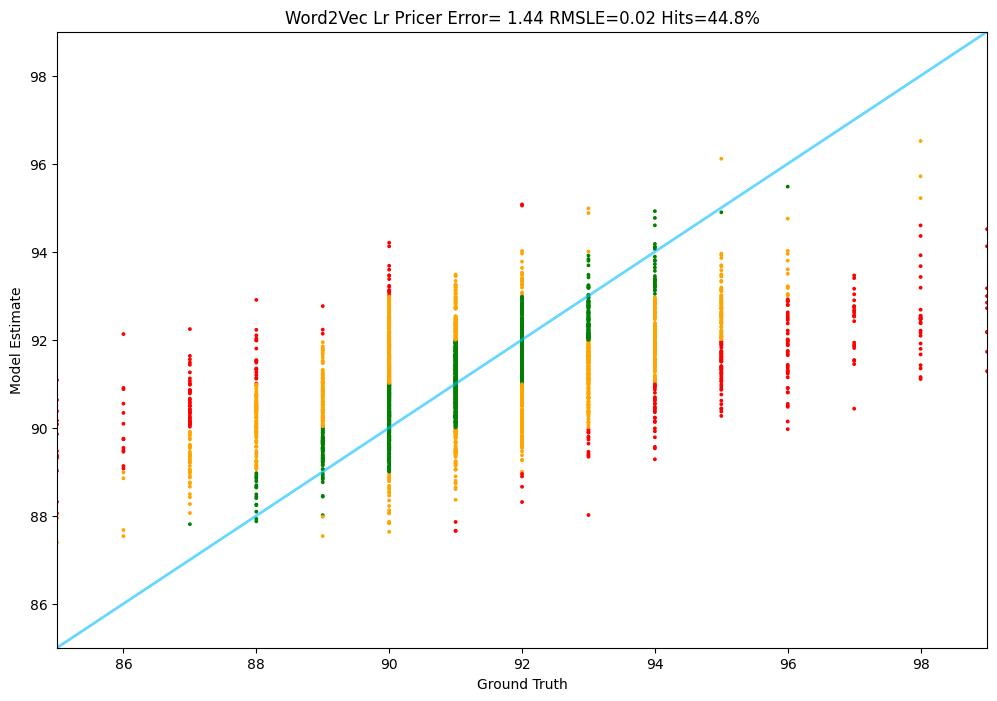

In [289]:
# Test the Word2Vec model with linear regression
Tester.test(word2vec_lr_pricer)

## Results of Word2Vec Model with Linear Regression

The Word2Vec model with linear regression achieved the following performance metrics:
- **Average Error**: 1.44
- **RMSLE (Root Mean Squared Log Error)**: 0.02
- **Hit Rate**: 44.8%

The scatter plot below shows the relationship between the predicted ratings and the ground truth ratings. The blue line represents the ideal scenario where predictions match the ground truth exactly. The points are color-coded based on the error level:
- **Green**: Error < 1
- **Orange**: Error < 3
- **Red**: Error ≥ 3

The Word2Vec model with linear regression performs similarly to the BoW model, with a slightly higher hit rate. This indicates that the semantic information captured by Word2Vec provides some additional predictive power, but the improvement is marginal. Further enhancements, such as using more advanced NLP techniques or combining multiple models, may be needed to achieve better performance.

## Support Vector Regression (SVR) with Word2Vec Features

In this section, we will implement a Support Vector Regression (SVR) model using Word2Vec features to predict wine ratings. SVR is a powerful machine learning algorithm that can capture non-linear relationships in the data. By combining SVR with Word2Vec features, we aim to improve the prediction accuracy compared to linear regression models.

We will:
1. Train an SVR model on the Word2Vec features.
2. Evaluate the model's performance on the test data.
3. Compare the results to our previous models.

In [290]:
# Support Vector Machines

np.random.seed(42)
# Initialize and train the SVR model
svr_regressor = LinearSVR()  # Use LinearSVR for support vector regression
svr_regressor.fit(X_w2v, ratings)  # Train the model on Word2Vec features and ratings

C:\Users\lyasy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR()

1: Guess: 89.99 Truth: 89.00 Error: 0.99 SLE: 0.00 Item: The Red Wine name is Calina Reserva Merl...
2: Guess: 93.01 Truth: 93.00 Error: 0.01 SLE: 0.00 Item: The Red Wine name is Chateau Montrose (3...
3: Guess: 90.07 Truth: 92.00 Error: 1.93 SLE: 0.00 Item: The Red Wine name is Castellare I Sodi S...
4: Guess: 91.48 Truth: 98.00 Error: 6.52 SLE: 0.00 Item: The Red Wine name is Abreu Vineyards Mad...
5: Guess: 90.81 Truth: 90.00 Error: 0.81 SLE: 0.00 Item: The White Wine name is Carlson Santa Yne...
6: Guess: 90.87 Truth: 90.00 Error: 0.87 SLE: 0.00 Item: The Pink and Rosé name is Chateau de Lan...
7: Guess: 91.71 Truth: 97.00 Error: 5.29 SLE: 0.00 Item: The White Wine name is Kistler Vineyards...
8: Guess: 91.88 Truth: 94.00 Error: 2.12 SLE: 0.00 Item: The Red Wine name is Betz Family Winery ...
9: Guess: 92.53 Truth: 93.00 Error: 0.47 SLE: 0.00 Item: The Red Wine name is Bond Quella 2011 an...
10: Guess: 90.72 Truth: 90.00 Error: 0.72 SLE: 0.00 Item: The Red Wine name is Avignonesi V

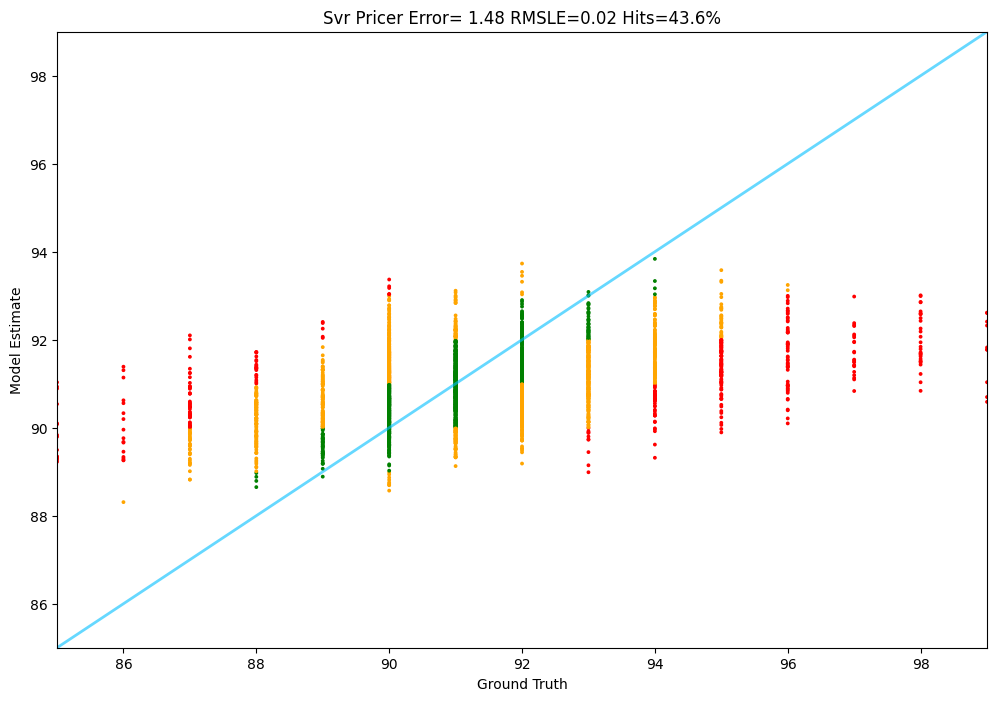

In [291]:
def svr_pricer(item):
    """
    Predict the wine rating using the SVR model with Word2Vec features.
    
    Args:
        item: The input item containing the wine description.
        
    Returns:
        float: The predicted wine rating.
    """
    np.random.seed(42)  # Set random seed for reproducibility
    doc = test_prompt(item)  # Preprocess the input text
    doc_vector = document_vector(doc)  # Convert the document to a Word2Vec feature vector
    return max(float(svr_regressor.predict([doc_vector])[0]), 0)  # Ensure the prediction is non-negative

# Test the SVR model
Tester.test(svr_pricer)

## Random Forest Regression with Word2Vec Features

In this section, we will implement a Random Forest Regression model using Word2Vec features to predict wine ratings. Random Forest is an ensemble learning method that combines multiple decision trees to improve prediction accuracy and reduce overfitting. By leveraging the semantic information captured by Word2Vec, we aim to further enhance the model's performance.

We will:
1. Train a Random Forest Regression model on the Word2Vec features.
2. Evaluate the model's performance on the test data.
3. Compare the results to our previous models.

In [292]:
# And the powerful Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)  # Initialize the Random Forest model
rf_model.fit(X_w2v, ratings)  # Train the model on Word2Vec features and ratings

RandomForestRegressor(n_jobs=8, random_state=42)

1: Guess: 87.86 Truth: 89.00 Error: 1.14 SLE: 0.00 Item: The Red Wine name is Calina Reserva Merl...
2: Guess: 93.25 Truth: 93.00 Error: 0.25 SLE: 0.00 Item: The Red Wine name is Chateau Montrose (3...
3: Guess: 90.34 Truth: 92.00 Error: 1.66 SLE: 0.00 Item: The Red Wine name is Castellare I Sodi S...
4: Guess: 93.84 Truth: 98.00 Error: 4.16 SLE: 0.00 Item: The Red Wine name is Abreu Vineyards Mad...
5: Guess: 90.65 Truth: 90.00 Error: 0.65 SLE: 0.00 Item: The White Wine name is Carlson Santa Yne...
6: Guess: 90.92 Truth: 90.00 Error: 0.92 SLE: 0.00 Item: The Pink and Rosé name is Chateau de Lan...
7: Guess: 92.71 Truth: 97.00 Error: 4.29 SLE: 0.00 Item: The White Wine name is Kistler Vineyards...
8: Guess: 93.97 Truth: 94.00 Error: 0.03 SLE: 0.00 Item: The Red Wine name is Betz Family Winery ...
9: Guess: 92.93 Truth: 93.00 Error: 0.07 SLE: 0.00 Item: The Red Wine name is Bond Quella 2011 an...
10: Guess: 90.66 Truth: 90.00 Error: 0.66 SLE: 0.00 Item: The Red Wine name is Avignonesi V

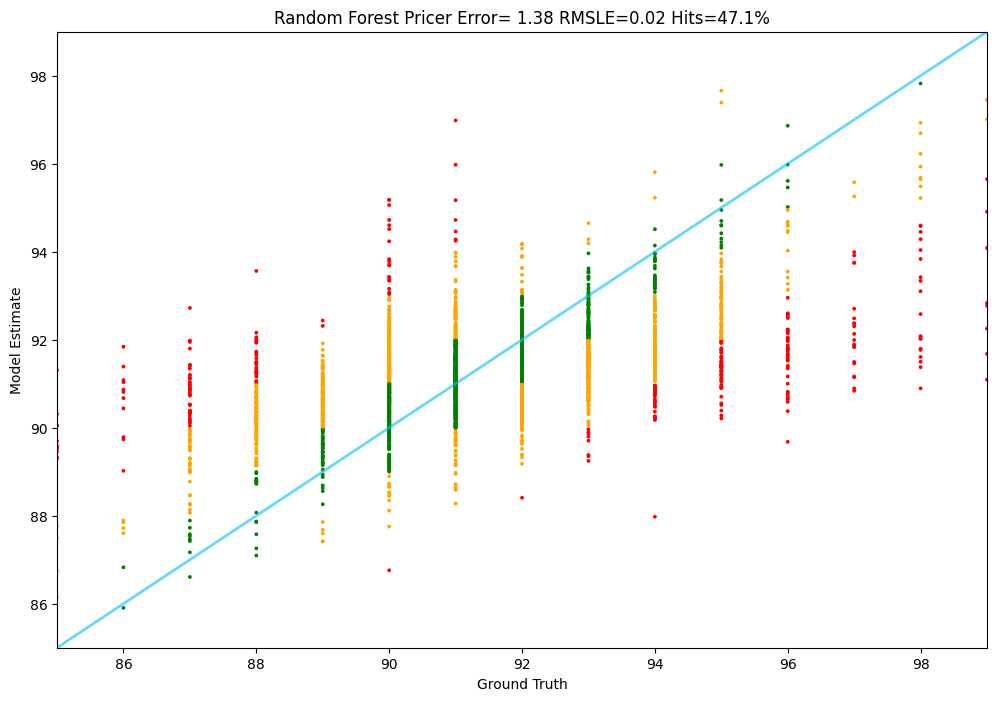

In [293]:
def random_forest_pricer(item):
    """
    Predict the wine rating using the Random Forest Regression model with Word2Vec features.
    
    Args:
        item: The input item containing the wine description.
        
    Returns:
        float: The predicted wine rating.
    """
    doc = test_prompt(item)  # Preprocess the input text
    doc_vector = document_vector(doc)  # Convert the document to a Word2Vec feature vector
    return max(0, rf_model.predict([doc_vector])[0])  # Ensure the prediction is non-negative

# Test the Random Forest Regression model
Tester.test(random_forest_pricer)

## Results of Random Forest Regression with Word2Vec Features

The Random Forest Regression model with Word2Vec features achieved the following performance metrics:
- **Average Error**: 1.38
- **RMSLE (Root Mean Squared Log Error)**: 0.02
- **Hit Rate**: 47.1%

The scatter plot below shows the relationship between the predicted ratings and the ground truth ratings. The blue line represents the ideal scenario where predictions match the ground truth exactly. The points are color-coded based on the error level:
- **Green**: Error < 1
- **Orange**: Error < 3
- **Red**: Error ≥ 3

The Random Forest model performs better than the previous models, with a lower average error and a higher hit rate. This indicates that the ensemble approach of Random Forest, combined with Word2Vec features, captures more of the variability in the data. However, there is still room for improvement, as the model does not fully explain all the nuances in the wine ratings.

## Notebook Summary

In this notebook, we explored various machine learning models to predict wine ratings based on textual descriptions and other features. We started with simple baseline models (random and constant predictors) and progressively moved to more sophisticated models, including linear regression, Bag of Words (BoW), Word2Vec, Support Vector Regression (SVR), and Random Forest Regression. Below is a summary of the results for each model:

| Model                          | Average Error | RMSLE  | Hit Rate |
|--------------------------------|---------------|--------|----------|
| Random Rating Predictor        | 5.36          | 0.07   | 4.7%     |
| Constant Rating Predictor      | 1.67          | 0.02   | 32.8%    |
| Linear Regression (Features)   | 1.67          | 0.02   | 33.9%    |
| BoW + Linear Regression        | 1.43          | 0.02   | 44.2%    |
| Word2Vec + Linear Regression   | 1.44          | 0.02   | 44.8%    |
| Word2Vec + SVR                 | 1.48          | 0.02   | 43.6%    |
| Word2Vec + Random Forest       | 1.38          | 0.02   | 47.1%    |

### Key Observations:
1. **Baseline Models**:
   - The random rating predictor performed poorly, as expected, with a high average error and low hit rate.
   - The constant rating predictor, which always predicts the average rating, performed significantly better but still lacked the ability to capture variability in the data.

2. **Feature-Based Models**:
   - Linear regression using features like year, variety, and region performed similarly to the constant predictor, indicating that these features alone are not sufficient for accurate predictions.

3. **Text-Based Models**:
   - The Bag of Words (BoW) model with linear regression showed a noticeable improvement, with a lower average error and higher hit rate, demonstrating the value of incorporating textual information.
   - Word2Vec models (with linear regression, SVR, and Random Forest) further improved performance, with the Random Forest model achieving the best results (average error of 1.38 and hit rate of 47.1%).

4. **Best Model**:
   - The **Random Forest Regression model with Word2Vec features** outperformed all other models, achieving the lowest average error and the highest hit rate. This highlights the power of ensemble methods and semantic text representations.

### Next Steps:
In the next notebook, we will explore the use of **OpenAI models** for wine rating prediction. OpenAI's advanced language models, such as GPT, have shown remarkable capabilities in understanding and generating text. By fine-tuning these models on our dataset, we aim to achieve even better performance and capture more nuanced relationships in the data.
